# Trajectory Planning 
- Computing the trajectory for a holonomic robot using polynomial functions. The robot starts at (3,0) at time t=0. The robot then must visit point (1,2.5) to collect a cookie for his friend, and then meet his friend at (9,5) to give her the cookie :') The robot must do so at t=5.  \
- We obtain the desired trajectory by first using a polynomial of degree 4, and then as a fifth degree Bernstein polynomial. On the way, we also meet an evil robot who tries to sabotage the cookie delivery. We compute a trajectory that avoids the obstacle. 


### Work Split 
- Abhinav computed the trajectory using a polynomial of degree 4, and Projit computed and plotted the velocities and accelerations. 
- For Bernstein polynomial, Projit computed the trajectory using various constraints and Abhinav plotted the graphs. 
- Both did the bonus together! 

Let's get started then!

As usual, we first import the required libraries.

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Polynomial Function of degree four

- We first formulate our problem as a polynomial of degree four in variable time 't'. We get 5 unknowns, from a0 to a5, which we wish to obtain.
- Since there are 5 unknowns, we need 5 constraints so as to get 5 equations in 5 variables, enabling us to obtain the values. 
![](./1.png)


- This function returns the output of our 4 variable polynomial for a value of t, that is passed as a parameter to it. 

In [166]:
def gen_output_t(a, t):
    final = []
    for t_val in t:
        total = 0
        for i in range(len(a)):
            temp = a[i] * (t_val**i)
            total += temp
        final.append(total)
    return final

- And this one differentiates the polynomial once, with respect to t. This helps us to compute the velocity constraints.
![]()

In [167]:
def differentiate_a(a):
    a_new = [a[i] * i for i in range(len(a))]
    return a_new[1:]

## Formulating Ma = b 

Since we need to solve a system of 5 equations in 5 variables, an efficient way to do that is to formulate it in a matrix form of Ma = b. Since there are 5 equations, M would be (5x5) and a and b would be (5x1). 
![]()

### Constraints
- The robot starts at initial time t0, picks up the cookie at time tc and reaches his friend at time tf.
- We can alter the values according to our convenience. for the given question, robot starts at t=0, picks up the cookie at t=2 and reaches his friend at t=5. We store these values.

In [168]:
tf = 5
tc = 2  
t0 = 0

- Constraint 1: Start Position **(3,0)**
- Constraint 2: Final Position **(9,5)**
- Constraint 3: Cookie Position **(1, 2.5)**
- Constraint 4: Initial Velocity **(0,0)**
- Constraint 5: Final Velocity **(0,0)**

Hence, we've got 5 constraints each for x and y, and now we can solve our system of equations!

In [169]:
x0 = 3
y0 = 0

xf = 9
yf = 5

x_cookie = 1
y_cookie = 2.5

x0_vel = 0
y0_vel = 0

xf_vel = 0
yf_vel = 0

#### Building the Coefficient Matrix 'M'

M contains the coefficients of the polynomial equation. We use x(t) and x_vel(t), where the latter is the derivative of the former. 
- The first row is x(t) for t = t0, when he starts
- The second row is x_vel(t) for t = t0
- The third row is x(t) for t = tf, when he finds his friend
- The fourth row is x_vel(t) for t = tf
- The fifth row is x(t) for t = tc, when he finds the cookie. 

We accordingly fill up bx and by. 

In [170]:
# M array is constant across both x and y
M = [   [1, t0,    t0**2, t0**3,   t0**4],
        [0, 1,     2*t0,  3*t0**2, 4*t0**3],
        [1, tf**1, tf**2, tf**3,   tf**4],
        [0, 1,     2*tf,  3*tf**2, 4*tf**3],
        [1, tc,    tc**2, tc**3,   tc**4]
    ]
M = np.array(M)

# Constraints in x and y
bx = np.array([x0, x0_vel, xf, xf_vel, x_cookie])
by = np.array([y0, y0_vel, yf, yf_vel, y_cookie])

#### Solving the system of equations
- Now we need to find the unknow matrix a. We do so bu multiplying the inverse of coefficient matrix 'M' with constraint matrices 'bx' and 'by'. 
- Note that M is constant across both, x and y, simply because the polynomial equations remain the same. Only the constraint values (bx and by) change. 

In [171]:
Minv = np.linalg.inv(M)
ax = Minv @ bx
ay = Minv @ by

- And there we are! We've computed the unknown matrix a. Our polynomial equation in variable t is complete!
- Now we compute the position of our robot (x,y) from time t=0 to t=5, with a time gap of 0.1 seconds. We store this in x and y.

In [172]:
time = []
i=0
while(i<5):
    time.append(i)
    i+=0.1
time = np.array(time)
    
x = gen_output_t(ax, time)
y = gen_output_t(ay, time)

## Plotting the trajectory

We've gotten the position of our robot (x,y) for various time instants. Let's plot this and see it visually. 

In [199]:
def plot(x,y):
    plt.figure()
    figure(figsize=(10, 7.5))
    plt.plot(x,y)
    plt.plot(xf,yf, 'bo')
    plt.plot(x0,y0, 'ro')
    plt.plot(x_cookie,y_cookie, 'ro')
    circle1=plt.Circle((5,4),2,color='g')
#     plt.gcf().gca().add_artist(circle1)
    plt.show()

<Figure size 432x288 with 0 Axes>

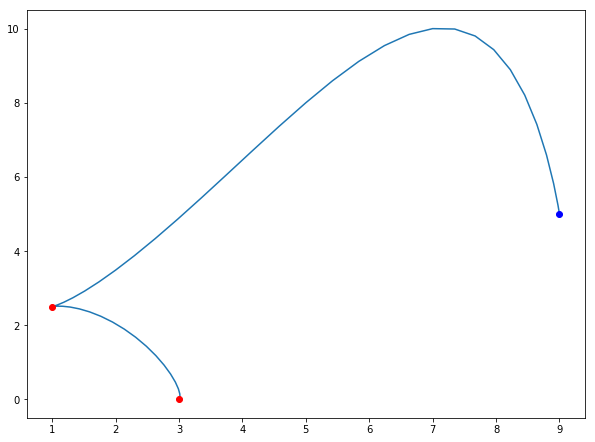

In [200]:
plot(x,y)

### Plotting velocity and acceleration

- Computing velocities and accelerations at different instants of time t.

In [201]:
diff_ax = differentiate_a(ax)
diff_ay = differentiate_a(ay)
x_vel = gen_output_t(diff_ax, time)
y_vel = gen_output_t(diff_ay, time)

diff2_ax = differentiate_a(diff_ax)
diff2_ay = differentiate_a(diff_ay)
x_acc = gen_output_t(diff2_ax, time)
y_acc = gen_output_t(diff2_ay, time)

In [202]:
def plot2(x,y, x_vel, y_vel, x_acc, y_acc):
    
    plt.figure()
    figure(figsize=(20, 10))

    plt.subplot(321)
    plt.title("X position vs Time")
    plt.plot(time, x)

    plt.subplot(322)
    plt.title("Y position vs Time")
    plt.plot(time, y)

    plt.subplot(323)
    plt.title("X velocity vs Time")
    plt.plot(time, x_vel) 

    plt.subplot(324)
    plt.title("Y velocity vs Time")
    plt.plot(time, y_vel) 
    
    plt.subplot(325)
    plt.title("X acceleration vs Time")
    plt.plot(time, x_acc) 
    
    plt.subplot(326)
    plt.title("Y acceleration vs Time")
    plt.plot(time, y_acc) 

<Figure size 432x288 with 0 Axes>

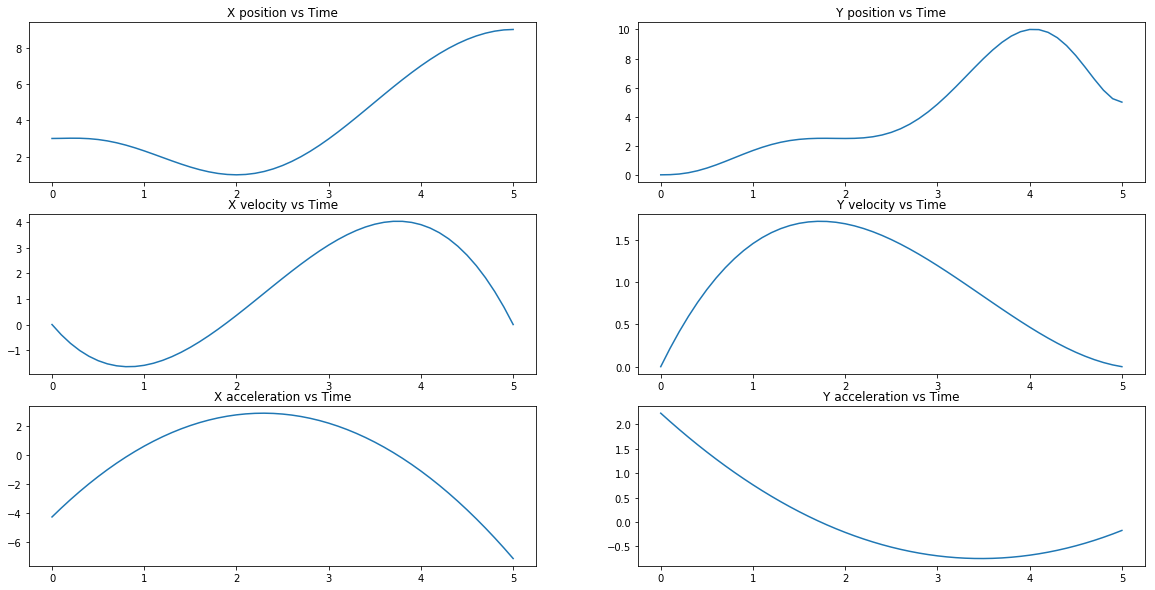

In [203]:
plot2(x,y, x_vel, y_vel, x_acc, y_acc)

## Bernstein Polynomial 

We now formulate a Bernstein polynomial in **5 variables** to compute the trajectory. The Bernstein polynomial is given by: \
![](./bernstein.png)

- These functions calculate nCr and factorial terms, that form the coefficients in the Bernstein polynomial. 

In [204]:
def nCr(n, r): 
    return (fact(n) / (fact(r)  * fact(n - r))) 
  
def fact(n): 
    res = 1
    for i in range(2, n+1): 
        res = res * i 
    return res 

### Formulating Ma = b
- Similar to the previous part, we get matrices M, a and b to solve the system of linear equations. 
- But here, we do a small trick - we split M into two matrices. 
- Due to this awesome manipulation, it becomes easy to implement a Bernstein generically, for as many variables as we like. 
- You can find this [here](http://graphics.cs.ucdavis.edu/education/CAGDNotes/Bernstein-Polynomials.pdf)
![](./trick.png)

- These functions compute the co-efficient matrix 

In [205]:
#Reference: http://graphics.cs.ucdavis.edu/education/CAGDNotes/Bernstein-Polynomials.pdf \
#Similar Reference: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.897.2894&rep=rep1&type=pdf 

# B(t) = [1 t t^2...t^n] * make_bern(n) * [c0 c1 c2...cn] = [b0 b1 b2..bn]

def calc_bernstein(i, j, n):
    temp = (-1) ** (i-j)
    return temp * nCr(n, i) * nCr(i, j)

def make_bern(n):
    mat = []
    for i in range(n+1):
        temp = []
        for j in range(n+1):
            if i<j:
                temp.append(0)
            else:
                temp.append(calc_bernstein(i, j, n))
        mat.append(temp)
    return np.array(mat)

- Since our polynomial is of degree 5, the coefficient matrix would be (5x5)

In [206]:
poly = make_bern(5)

- This function computes the coefficients of the polynomial for a time 't', which is then inserted as a row into the coefficient matrix.

In [207]:
def eval_pos(poly, t):
    temp = []
    for i in range(len(poly)):
        val = 0
        for j in range(len(poly)):
            val += poly[j][i] * t **j
        temp.append(val)
    return temp

- Similarly, the next two functions compute the coefficients of the velocity and acceleration polynomials, which are obtained after differentiating the original bernstein polynomial once and twice respectively. 

In [208]:
def eval_vel(poly, t):
    temp = []
    for i in range(len(poly)):
        val = 0
        for j in range(len(poly)):
            if j-1 < 0:
                val += 0
            else: 
                val += j * poly[j][i] * t **(j-1)
        temp.append(val)
    return temp

def eval_acc(poly, t):
    temp = []
    for i in range(len(poly)):
        val = 0
        for j in range(len(poly)):
            if j-2 < 0:
                val += 0
            else:
                val += j * (j-1) * poly[j][i] * t **(j-2)
        temp.append(val)
    return temp

## Building the M matrix

Now we build the (5x5) M matrix, by computing the coefficients for each constraint equation and appending it to M.
- At time t=0, robot starts at (3,0). So we call eval_pos, which computes the position coefficients. 

In [209]:
M = []
bx = []
by = []

coefs1 = eval_pos(poly, t0)
M.append(coefs1)

- Now the robot picks up the cookie at (1,2.5) at t=2. 

In [210]:
coefs2 = eval_pos(poly, tc)
M.append(coefs2)

- And finally the robot reaches his friend at (9,5) at t = 5

In [211]:
coefs3 = eval_pos(poly, tf)
M.append(coefs3)

- So we have got three constraints each for x and y, all of which are related to position. 
- Now we compute velocity constraints. 
- The velocity of robot in both directions is (0,0) at t=0

In [212]:
coefs4 = eval_vel(poly, t0)
M.append(coefs4)

- And when it reaches his friend, it reaches with final velocity as (0,0) because it must not crash into his friend!

In [213]:
coefs5 = eval_vel(poly, tf)
M.append(coefs5)

- We add another constraint, saying that his velocity when he reaches the cookie must also be zero to avoid any possibility of a collision. 

In [214]:
x_cookie_vel = 0
y_cookie_vel = 0
coefs6 = eval_vel(poly, tc)
M.append(coefs6)

In [215]:
# Constraints in x and y 
bx = np.array([x0, x_cookie, xf, x0_vel, xf_vel, x_cookie_vel])
by = np.array([y0, y_cookie, yf, y0_vel, yf_vel, y_cookie_vel])

M = np.array(M)
bx = np.array(bx)
by = np.array(by)

- We now have bx, by and M. 
- We can solve the system of equations, by multiplying the inverse of M with the constraint matrices bx and by.

In [216]:
cx = np.linalg.inv(M) @ bx.T
cy = np.linalg.inv(M) @ by.T

- And voila! We've computed the unknowns!
- Now we compute the position of our robot (x,y) from time t=0 to t=5, with a time gap of 0.1 seconds. We store this in x and y. 
- These functions compute the output of our bernstein polynomial for position, velocity and acceleration.

In [217]:
def output_pos(poly_5, c, t):
    return np.array(eval_pos(poly, t)) @ c.T

def output_vel(poly_5, c, t):
    return np.array(eval_vel(poly, t)) @ c.T

def output_acc(poly_5, c, t):
    return np.array(eval_acc(poly, t)) @ c.T

## Plotting the trajectory

In [218]:
x = [output_pos(poly, cx, t) for t in time]
y = [output_pos(poly, cy, t) for t in time]

x_vel = [output_vel(poly, cx, t) for t in time]
y_vel = [output_vel(poly, cy, t) for t in time]

x_acc = [output_acc(poly, cx, t) for t in time]
y_acc = [output_acc(poly, cy, t) for t in time]

<Figure size 432x288 with 0 Axes>

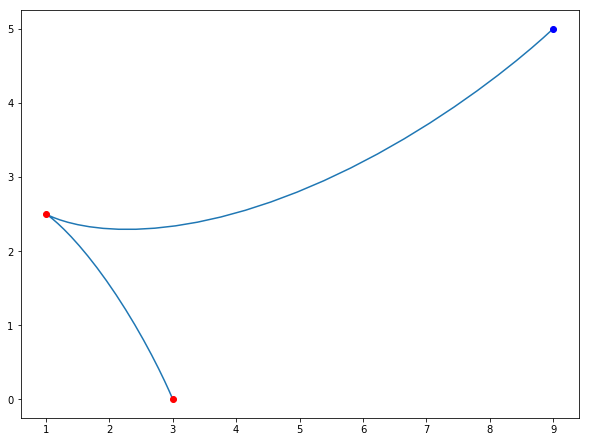

In [219]:
plot(x,y)

### Awesome right? ^
- As we can see, the robot makes a nice stop at (1,2.5) 
- This is because we put a constraint saying that when the robot reaches the cookie, its velocity must be zero! 

### Position, Velocity and Accelerations

<Figure size 432x288 with 0 Axes>

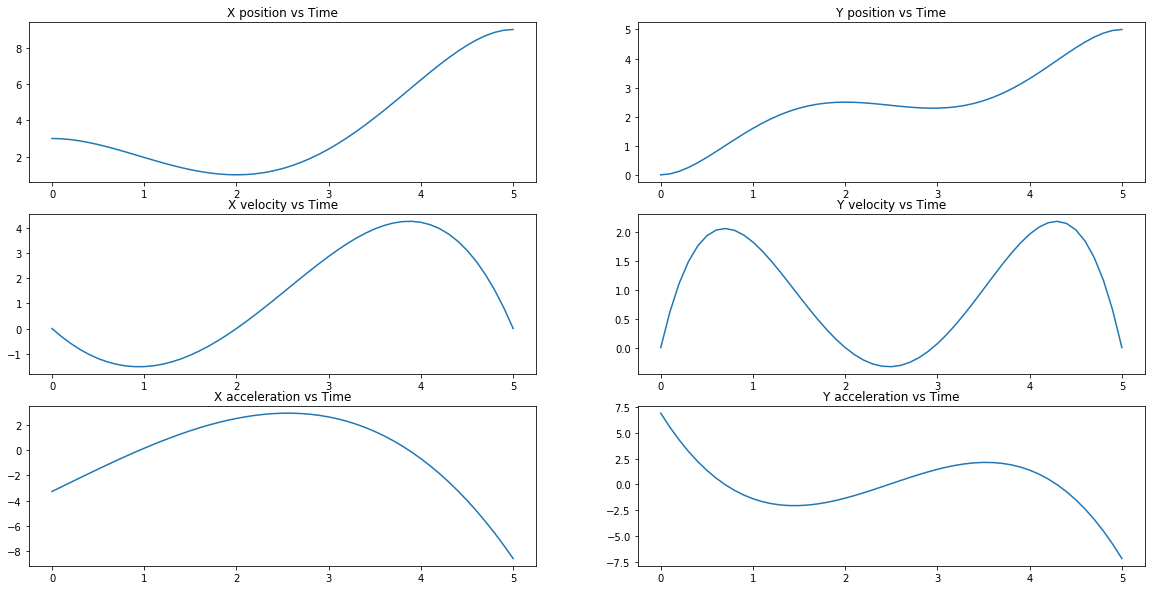

In [220]:
plot2(x,y, x_vel, y_vel, x_acc, y_acc)

## Evil Robot!!!


- An evil robot of radius 2 units appears at (5, 4) trying to steal our cookie. The robot, whose radius is 1 unit, must avoid this evil robot in order to successfully deliver the cookie.
- We must find a way to avoid the evil robot and not come in contact with him.
- So we assume 2 additional constraints, that would ensure our robot takes a path that is far from the evil robot. 
- Given that the robot is of radius 2 units and appears at (5,4)
- This means that the range of the robot is from **x=3 to x=7** and from **y=2 to y=6**.
- Here's what we do: we sample some points that are outside the range of the evil robot, and add this as a constraint to our robot's trajectory. That way, our robot would try to go through these points, thereby avoiding coming into the range of the evil robot. 
- Our robot's radius is 1 unit.


### Additional Constraints:
- At t = 3.5, the robot is at (5,8)
- At t = 4, the robot is at (7, 10)

In [221]:
M = []
poly = make_bern(7)

coefs1 = eval_pos(poly, t0)
M.append(coefs1)

coefs2 = eval_pos(poly, tc)
M.append(coefs2)

coefs3 = eval_pos(poly, tf)
M.append(coefs3)

coefs4 = eval_vel(poly, t0)
M.append(coefs4)

coefs5 = eval_vel(poly, tf)
M.append(coefs5)

coefs6 = eval_vel(poly, tc)
M.append(coefs6)

coefs7 = eval_pos(poly, tc+1.5)
M.append(coefs7)

coefs8 = eval_pos(poly, tc+2)
M.append(coefs8)

M = np.array(M)

In [222]:
# Constraints in x and y 
bx = [x0, x_cookie, xf, x0_vel, xf_vel, x_cookie_vel]
by = [y0, y_cookie, yf, y0_vel, yf_vel, y_cookie_vel]

bx.append(5)
bx.append(7)

by.append(8)
by.append(10)

bx = np.array(bx)
by = np.array(by)

cx = np.linalg.inv(M) @ bx.T
cy = np.linalg.inv(M) @ by.T

In [223]:
x = [output_pos(poly, cx, t) for t in time]
y = [output_pos(poly, cy, t) for t in time]

x_vel = [output_vel(poly, cx, t) for t in time]
y_vel = [output_vel(poly, cy, t) for t in time]

x_acc = [output_acc(poly, cx, t) for t in time]
y_acc = [output_acc(poly, cy, t) for t in time]

<Figure size 432x288 with 0 Axes>

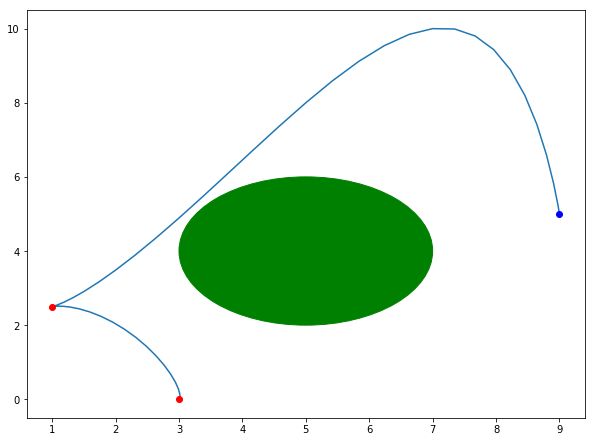

In [198]:
plot(x,y)